In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')

### Import dataset

In [108]:
df = pd.read_csv('aggregated_df_final01oct2021.csv')
#df['time']=df['time'].to_datetime(dayfirst=True).astype(int)
df[['sentiment_Extreme Fear', 'sentiment_Extreme Greed', 'sentiment_Fear','sentiment_Greed', 'sentiment_Neutral']]=df[['sentiment_Extreme Fear', 'sentiment_Extreme Greed', 'sentiment_Fear','sentiment_Greed', 'sentiment_Neutral']].fillna(0)

df['time'] = pd.to_datetime(df['time'], dayfirst=True)
df.set_index('time', drop=True, inplace=True)
df.sort_index(inplace=True)
df=df.interpolate(method='linear')
df = df.fillna(method='bfill')

df.head()

,open_x,high_x,low_x,close_x,Basis_x,Volume_x,RSI_x,MACD_x,OnBalanceVolume_x,btc_dom,...,btc_s2f,btc_s2f_price,nlp_compound,nlp_subjectivity,nlp_polarity,sentiment_Extreme Fear,sentiment_Extreme Greed,sentiment_Fear,sentiment_Greed,sentiment_Neutral
time,,,,,,,,,,,,,,,,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,4328.539,795.150377,67.858274,8.179071,-1199.888264,57.599479,...,20.219069,3874.856716,0.304444,0.330198,0.104973,0.0,0.0,0.0,0.0,0.0
2017-08-18,4285.08,4371.52,3938.77,4108.37,4328.539,1199.888264,67.858274,8.179071,-1199.888264,55.505251,...,24.292762,7179.604986,0.275072,0.300219,0.091723,0.0,0.0,0.0,0.0,0.0
2017-08-19,4108.37,4184.69,3850.00,4139.98,4328.539,381.309763,67.858274,8.179071,-818.578501,54.096402,...,23.973744,6867.689316,0.242156,0.290819,0.059914,0.0,0.0,0.0,0.0,0.0
2017-08-20,4120.98,4211.08,4032.62,4086.29,4328.539,467.083022,67.858274,8.179071,-1285.661523,53.881711,...,27.849165,11362.321705,0.219211,0.256419,0.122539,0.0,0.0,0.0,0.0,0.0
2017-08-21,4069.13,4119.62,3911.79,4016.00,4328.539,691.743060,67.858274,8.179071,-1977.404583,52.805377,...,31.484405,17159.277080,0.356947,0.277829,0.092228,0.0,0.0,0.0,0.0,0.0


In [109]:
df = df['close_x']
df.head()

time
2017-08-17    4285.08
2017-08-18    4108.37
2017-08-19    4139.98
2017-08-20    4086.29
2017-08-21    4016.00
Name: close_x, dtype: float64

In [110]:
def take_last(array_like):
    return array_like[-1]
    
df = df.resample('M').agg({'close_x': take_last})
df = df.droplevel(0)
df[0:5]

time
2017-08-31     4724.890000
2017-09-30     4378.510000
2017-10-31     6386.600001
2017-11-30     9827.111193
2017-12-31    13324.680001
Freq: M, Name: close_x, dtype: float64

### EDA
- Closing price boxplot
- ACF and PACF
- Stationarity check (mean and variance)
    - ADF test
    - KSS test

D:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning:

Mean of empty slice.

D:\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



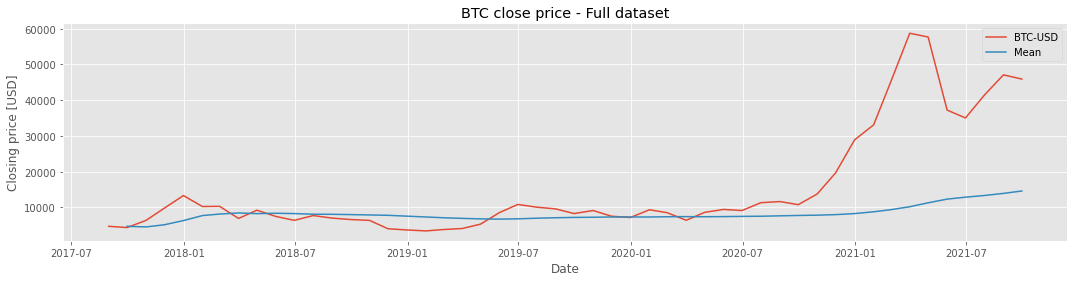

In [111]:
mean = [np.mean(df.values[:x]) for x in range(df.shape[0])]
plt.figure(figsize=(18,4))
sns.lineplot(x=df.index ,y=df, label='BTC-USD', ci='sd')
sns.lineplot(x=df.index, y=mean, label='Mean', ci=None)
plt.title('BTC close price - Full dataset')
plt.ylabel('Closing price [USD]')
plt.xlabel('Date')
plt.show()

From this we can see that the data is not stationary, as both the mean and the variance are increasing over time.

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



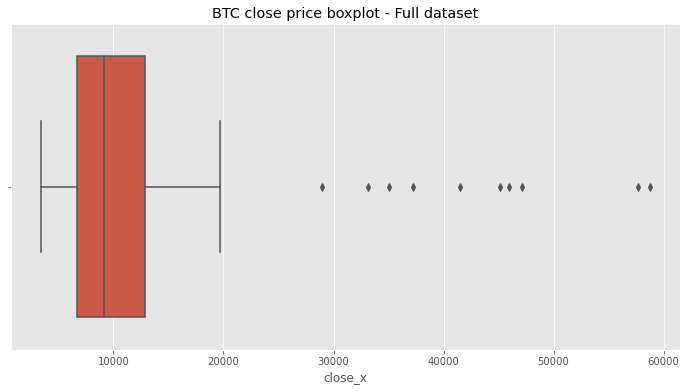

In [116]:
plt.figure(figsize=(12,6))
sns.boxplot(df)
plt.title('BTC close price boxplot - Full dataset')
plt.show()

### __Preprocessing__
- Train/test split
- Stationarity check (mean and variance)
    - Seasonal decompose of train
    - ADF test
    - KSS test
- Stationarity transformation
- LSTM data transformation

#### Train/Test split

In [144]:
# Train/Test split

# Number of periods to incluse in validation split
val_periods = 10

df_train = df[:df.shape[0]-val_periods]
df_val = df[df.shape[0]-val_periods:]

print('Train shape', df_train.shape)
print('Validation shape', df_val.shape)

Train shape (40,)
Validation shape (10,)


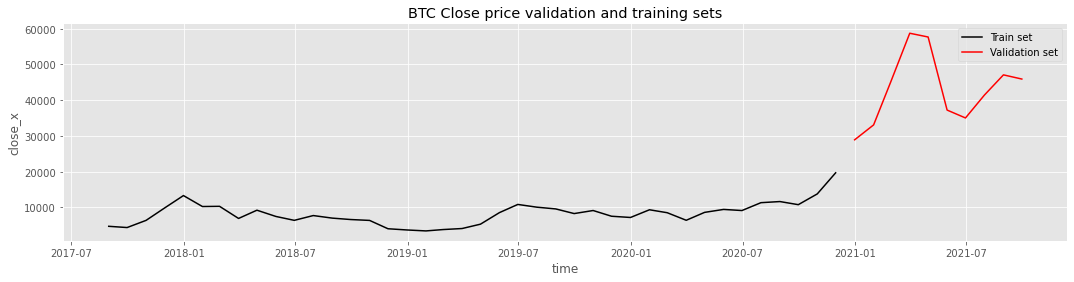

In [145]:
plt.figure(figsize=(18,4))
sns.lineplot(data=df_train, color='black', label = 'Train set', ci='sd')
sns.lineplot(data=df_val, color='red', label='Validation set', ci='sd')
plt.title('BTC Close price validation and training sets')
plt.show()

#### Min Max Scaling

In [146]:
scaler = MinMaxScaler()
df_train_scaled = scaler.fit_transform(df_train.values.reshape(-1,1))
df_train_scaled.shape

(40, 1)

In [147]:
# Head and tail of scaled dataset
df_train_scaled

array([[0.07933714],
       [0.05803588],
       [0.18152702],
       [0.39310751],
       [0.60819686],
       [0.41967037],
       [0.42301149],
       [0.21463414],
       [0.35651037],
       [0.24881873],
       [0.18194814],
       [0.26430728],
       [0.22023213],
       [0.19593173],
       [0.18068339],
       [0.03724801],
       [0.01635186],
       [0.        ],
       [0.02337627],
       [0.04114362],
       [0.11594712],
       [0.31489517],
       [0.45555684],
       [0.40857112],
       [0.37827594],
       [0.2984829 ],
       [0.35092769],
       [0.25266316],
       [0.23128194],
       [0.36385863],
       [0.31305364],
       [0.18297896],
       [0.31912922],
       [0.36988977],
       [0.35071014],
       [0.48591105],
       [0.50525103],
       [0.45152249],
       [0.63685407],
       [1.        ]])

#### Reshaping

In [218]:
# Transforms the original time series into the input formar required by the LSTM model

nb_timesteps = 2

def makeXy(ts, nb_timesteps, features='itself'): 
    """ 
    Input:  
           ts: original scaled time series 
           nb_timesteps: number of time steps in the regressors 
           features: itself == use the previous values of the label only
                     all == use previous values of all avaialable data
    Output:  
           X: 2-D array of regressors 
           y: 1-D array of target  
   """
    x_train = []
    y_train = []

    for i in range(nb_timesteps, ts.shape[0]):
        if features == 'itself':
            x_train.append(ts[i-nb_timesteps:i,-1])
        else:
            x_train.append(ts[i-nb_timesteps:i, 0:])
        y_train.append(ts[i, -1])

    x_train, y_train = np.array(x_train), np.array(y_train)
    return x_train, y_train 

In [219]:
# Reshape training data into (samples, timestamp, features)

X_train, y_train = makeXy(df_train_scaled, nb_timesteps)
print('Train dataset shape:', X_train.shape, y_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

Train dataset shape: (38, 2) (38,)


(38, 2, 1)

In [220]:
# Reshape validation data
data = pd.concat([df_train, df_val], axis=0)
data.reset_index(inplace=True, drop=True)

val_inputs = data[df_train_scaled.shape[0]-nb_timesteps:].values
#val_inputs.reshape(-1,1)
# Scale validation inputs
val_inputs = scaler.transform(val_inputs.reshape(-1,1))

X_val, y_val = makeXy(val_inputs, nb_timesteps)
print('Train dataset shape:', X_val.shape, y_val.shape)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_val.shape

Train dataset shape: (10, 2) (10,)


(10, 2, 1)

### LSTM Model

In [221]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, InputLayer
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [244]:
# Define LSTM Neural Network
regressor = Sequential()

regressor.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(LSTM(units=100, return_sequences=True, ))
regressor.add(Dropout(rate=0.3))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(rate=0.3))
regressor.add(LSTM(units=75, return_sequences=True))
regressor.add(Dropout(rate = 0.2))
regressor.add(LSTM(units=50))
regressor.add(Dropout(rate = 0.2))
regressor.add(Dense(units=1))


regressor.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 2, 100)            40800     
_________________________________________________________________
dropout_40 (Dropout)         (None, 2, 100)            0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 2, 100)            80400     
_________________________________________________________________
dropout_41 (Dropout)         (None, 2, 100)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 2, 75)             52800     
_________________________________________________________________
dropout_42 (Dropout)         (None, 2, 75)             0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 50)              

In [245]:
# Create directory to save model
!mkdir "keras_models_lstm1D_monthly"

A subdirectory or file keras_models_lstm1D_monthly already exists.


In [246]:
# Fit and save best parameters of model
epoch = 50

# Compiler and loss function
regressor.compile(loss='mean_squared_error', optimizer='adam')

# Model Checkpoint
model_folder ='keras_models_lstm1D'
model_file = 'BTC_close_price_lstm_weights.hdf5'
save_weights_at = os.path.join(model_folder, model_file) 
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0, 
                            save_best_only=True, save_weights_only=False, mode='min', 
                            save_freq='epoch') 
# Fit model
regressor.fit(x=X_train, y=y_train, batch_size=32, epochs=epoch, 
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val), 
             shuffle=True) 

Epoch 1/50
2/2 [==============================] - 1s 636ms/step - loss: 0.1326 - val_loss: 6.1865
Epoch 2/50
2/2 [==============================] - 0s 56ms/step - loss: 0.1243 - val_loss: 6.0928
Epoch 3/50
2/2 [==============================] - 0s 49ms/step - loss: 0.1153 - val_loss: 5.9831
Epoch 4/50
2/2 [==============================] - 0s 55ms/step - loss: 0.1065 - val_loss: 5.8493
Epoch 5/50
2/2 [==============================] - 0s 45ms/step - loss: 0.0954 - val_loss: 5.6831
Epoch 6/50
2/2 [==============================] - 0s 58ms/step - loss: 0.0843 - val_loss: 5.4708
Epoch 7/50
2/2 [==============================] - 0s 49ms/step - loss: 0.0723 - val_loss: 5.1991
Epoch 8/50
2/2 [==============================] - 0s 57ms/step - loss: 0.0597 - val_loss: 4.8518
Epoch 9/50
2/2 [==============================] - 0s 41ms/step - loss: 0.0508 - val_loss: 4.4128
Epoch 10/50
2/2 [==============================] - 0s 45ms/step - loss: 0.0389 - val_loss: 3.8858
Epoch 11/50
2/2 [===========

In [247]:
regressor.load_weights(model_folder + '\\' + 'BTC_close_price_lstm_weights.hdf5') 
# Validation predict
predicted_price = regressor.predict(X_val)
predicted_price = scaler.inverse_transform(predicted_price)
predicted_price = predicted_price.reshape(X_val.shape[0])

# Train predict
predicted_price_train = regressor.predict(X_train)
predicted_price_train = scaler.inverse_transform(predicted_price_train)
predicted_price_train = predicted_price_train.reshape(X_train.shape[0])

In [248]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print('Train RMSE:')
train_mape = mean_absolute_percentage_error(df_train[:df_train.shape[0]-nb_timesteps],predicted_price_train)
print(train_mape)
train_rmse = np.sqrt(np.mean(np.square(df_train[:df_train.shape[0]-nb_timesteps]-predicted_price_train)))
print(train_rmse)

print('Validation RMSE:')
test_mape = mean_absolute_percentage_error(df_val,predicted_price)
print(test_mape)
test_rmse = np.sqrt(np.mean(np.square(df_val-predicted_price)))
test_rmse

Train RMSE:
0.27819589001183936
1830.1896224975626
Validation RMSE:
0.31227432323638105


14297.394942505445

In [249]:
import plotly.express as px
train_results = pd.DataFrame(df_train[:df_train.shape[0]-nb_timesteps])
train_results['train_pred'] = predicted_price_train
px.line(train_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Training data \
        <br><span style="font-size: 13px;color:#444444;">Train RMSE: {:.1f} <br>Train MAPE: {:.1%}</span>'.format(train_rmse, train_mape ))

In [250]:
test_results = pd.DataFrame(df_val)
test_results['test_pred'] = predicted_price
px.line(test_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Validation RMSE: {:.1f} <br>Train MAPE: {:.1%}</span>'.format(test_rmse, test_mape ))
# plt.figure(figsize=(19,6))
# plt.plot(df_val.index, df_val)
# plt.plot(df_val.index, predicted_price)
# plt.title('BTC-USD Close price prediction - Validation')
# plt.xlabel('Date')
# plt.ylabel('USD')

In [251]:
total_results = pd.concat([train_results,test_results])

px.line(total_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Total data \
        <br><span style="font-size: 13px;color:#444444;">Train RMSE: {:.1f} ; Train MAPE: {:.1%}<br>Validation RMSE: {:.1f} ; Test MAPE: {:.1%} </span>'.format(train_rmse, train_mape, test_rmse, test_mape))

In [252]:
blabla = pd.DataFrame(scaler.inverse_transform(val_inputs))
blabla

,0
0,13790.67500
1,19695.79250
2,28926.65750
3,33100.89500
4,45147.96500
5,58745.58750
6,57694.21750
7,37248.60750
8,35043.71000
9,41460.99000


In [253]:
X_val

array([[[0.63685407],
        [1.        ]],

       [[1.        ],
        [1.56766882]],

       [[1.56766882],
        [1.82437114]],

       [[1.82437114],
        [2.5652276 ]],

       [[2.5652276 ],
        [3.40143811]],

       [[3.40143811],
        [3.3367822 ]],

       [[3.3367822 ],
        [2.07944226]],

       [[2.07944226],
        [1.94384808]],

       [[1.94384808],
        [2.33849038]],

       [[2.33849038],
        [2.68523472]]])

In [254]:
val_inputs

array([[0.63685407],
       [1.        ],
       [1.56766882],
       [1.82437114],
       [2.5652276 ],
       [3.40143811],
       [3.3367822 ],
       [2.07944226],
       [1.94384808],
       [2.33849038],
       [2.68523472],
       [2.61334533]])